In [222]:
import pandas as pd
import torch
import os
from PIL import Image
from torch import device
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [223]:
img_dir = 'archive/img_align_celeba/img_align_celeba'
partition_file = 'archive/list_eval_partition.csv'
attributes_file = 'archive/list_attr_celeba.csv'

partition_df = pd.read_csv(partition_file)
attributes_df = pd.read_csv(attributes_file)

# Merge partition and attributes datasets
merged_df = pd.merge(partition_df, attributes_df,on='image_id')

# Map partition values to names
partition_map = {0: 'train', 1: 'valid', 2: 'test'}
merged_df['partition'] = merged_df['partition'].map(partition_map)

# We only want to classify the smile
merged_df = merged_df[['image_id', 'partition', 'Smiling']]
merged_df.loc[merged_df['Smiling']==-1, 'Smiling'] = 0

merged_df.head(5)

,image_id,partition,Smiling
0,000001.jpg,train,1
1,000002.jpg,train,1
2,000003.jpg,train,0
3,000004.jpg,train,0
4,000005.jpg,train,0


The transformations for the training dataset augment the dataset by adding variability (through random cropping and flipping) and resize images to a consistent size. This helps prevent overfitting, improves the model’s ability to handle different orientations and perspectives, and ensures consistent input dimensions, making the training process more robust and efficient.

In [224]:
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

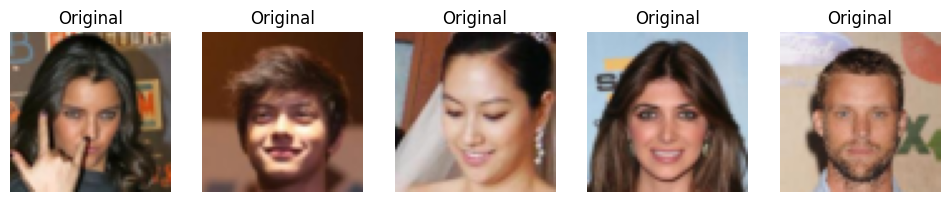

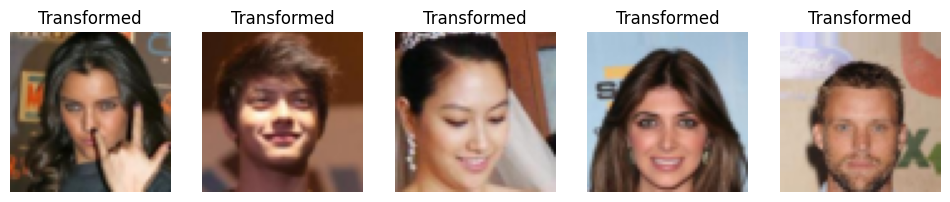

In [225]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

def plot_images(images, titles=None):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    if num_images == 1:
        axes = [axes]
    for ax, img, title in zip(axes, images, titles or [''] * num_images):
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax.set_title(title)
        ax.axis('off')
    plt.show()

# Get 5 random indices from the training set
indices = np.random.choice(len(merged_df[merged_df['partition'] == 'train']), 5, replace=False)

# Load and transform images
original_images = []
transformed_images = []

for idx in indices:
    img_name = merged_df.iloc[idx]["image_id"]
    img_path = os.path.join(img_dir, img_name)

    img = Image.open(img_path).convert('RGB')
    original_images.append(transform(img))
    transformed_images.append(transform_train(img))

# Plot images
plot_images(original_images, titles=['Original']*5)
plot_images(transformed_images, titles=['Transformed']*5)


In [226]:
class CelebADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]  # Get the image filename
        img_path = os.path.join(self.img_dir, img_name)  # Construct full image path
        image = Image.open(img_path).convert('RGB')  # Open and ensure image is in RGB mode
        
        # Get the label (Smiling column)
        label = self.df.iloc[idx, 2]  # Index 2 corresponds to 'Smiling' column

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float)

In [227]:
train_df = merged_df[merged_df['partition'] == 'train'].sample(n=16000)
valid_df = merged_df[merged_df['partition'] == 'valid'].sample(n=1000)
test_df = merged_df[merged_df['partition'] == 'test']

train_dataset = CelebADataset(train_df, img_dir, transform=transform_train)
valid_dataset = CelebADataset(valid_df, img_dir, transform=transform)
test_dataset = CelebADataset(test_df, img_dir, transform=transform)

print(f'Train set length: {len(train_dataset)}')
print(f'Valid set length: {len(valid_dataset)}')

Train set length: 16000
Valid set length: 1000


In [228]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

## Training CNN smile classifier

In [229]:
import torch.nn as nn

In [230]:
# current size: batch x 3(RGB) x 64 x 64
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2)) # reduces spatial dimensions by 2
model.add_module('dropout1', nn.Dropout(p=0.5))

# current size: batch x 32 x 32 x 32
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

# current size: batch x 64 x 16 x 16
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module('dropout3', nn.Dropout(p=0.5))

# current size: batch x 128 x 8 x 8
model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1))
model.add_module('relu4', nn.ReLU())

In [231]:
# check shape of the output feature maps using a toy 4 batch
x = torch.ones((4, 3, 64, 64)) # 64x64 because of the resize done by the transform
model(x).shape

torch.Size([4, 256, 8, 8])

There are 256 feature maps (or channels) of size 8×8.  

In [232]:
model.add_module('pool4', nn.AvgPool2d(kernel_size=8)) # Global Avg-pooling
# current size: batch x 256 x 1 x 1
model.add_module('flatten', nn.Flatten())
# current size: batch x 256

In [233]:
model(x).shape

torch.Size([4, 256])

Finally, we add a fully connected layer to a simple output unit. This let us use sigmoid activation.

In [234]:
model.add_module('fc', nn.Linear(in_features=256, out_features=1))
model.add_module('sigmoid', nn.Sigmoid())
# final size: batch x 1

In [235]:
model(x).shape

torch.Size([4, 1])

Then, our final model looks like this:

In [236]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [237]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

Now, we define a loss function and an optimizer. The loss function, as we are working with a binary classification with a single probabilistic output, we will use Binary Cross-Entropy Loss (we could've also put 2 final neurons and a Softmax layer for a Cross-Entropy Loss, but it is not necessary since 1 output is enough). And for the optimizer, Adam.

In [238]:
loss_fn = nn.BCELoss()
# loss_fn = nn.BCEWithLogitsLoss() # this one is to be used if the final layer wasn't a sigmoid
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0025)

device = torch.device("cuda:0")
model = model.to(device)

In [239]:
torch.manual_seed(0)
epochs = 35
hist = train(model, epochs, train_loader, valid_loader)

Epoch 1 accuracy: 0.5108 val_accuracy: 0.5490
Epoch 2 accuracy: 0.5217 val_accuracy: 0.5380
Epoch 3 accuracy: 0.5448 val_accuracy: 0.6020
Epoch 4 accuracy: 0.5658 val_accuracy: 0.5670
Epoch 5 accuracy: 0.5775 val_accuracy: 0.6220
Epoch 6 accuracy: 0.5883 val_accuracy: 0.5390
Epoch 7 accuracy: 0.5957 val_accuracy: 0.6200
Epoch 8 accuracy: 0.6121 val_accuracy: 0.5920
Epoch 9 accuracy: 0.6203 val_accuracy: 0.6480
Epoch 10 accuracy: 0.6379 val_accuracy: 0.6290
Epoch 11 accuracy: 0.6463 val_accuracy: 0.6190
Epoch 12 accuracy: 0.6585 val_accuracy: 0.6040
Epoch 13 accuracy: 0.6601 val_accuracy: 0.6880
Epoch 14 accuracy: 0.6676 val_accuracy: 0.7080
Epoch 15 accuracy: 0.6734 val_accuracy: 0.6990
Epoch 16 accuracy: 0.6823 val_accuracy: 0.6950
Epoch 17 accuracy: 0.6806 val_accuracy: 0.6890
Epoch 18 accuracy: 0.6890 val_accuracy: 0.7320
Epoch 19 accuracy: 0.6973 val_accuracy: 0.6980
Epoch 20 accuracy: 0.7006 val_accuracy: 0.7450
Epoch 21 accuracy: 0.7171 val_accuracy: 0.7810
Epoch 22 accuracy: 0.7

TypeError: 'bool' object is not iterable

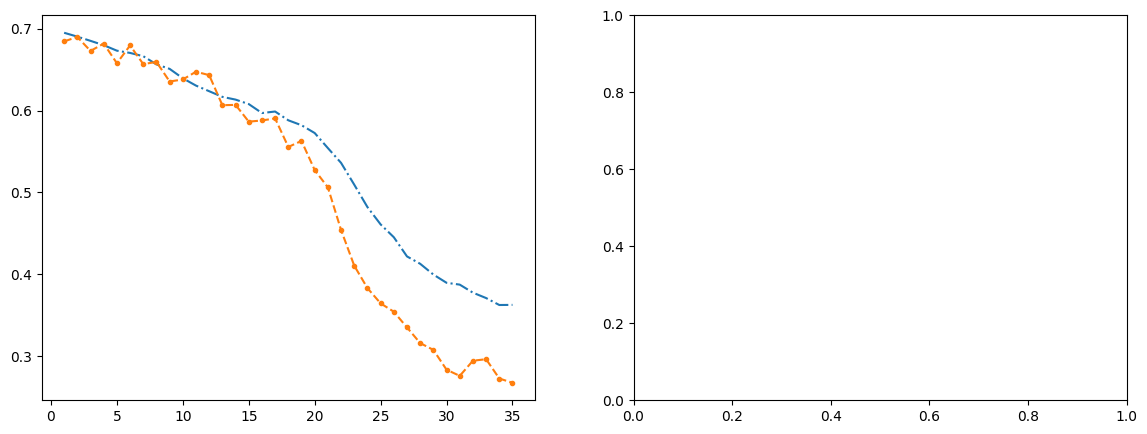

In [263]:
x_arr = np.arange(len(hist[0])) + 1

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax[0].plot(x_arr, hist[0], '-.', label='Train loss')
ax[0].plot(x_arr, hist[1], '--.', label='Validation loss')
ax[0].legend(True)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(x_arr, hist[2], '-.', label='Train acc.')
ax[1].plot(x_arr, hist[3], '--.', label='Validation acc.')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

ax[0].set_title('Learning curve (Loss)')
ax[1].set_title('Learning curve (Accuracy)')

plt.tight_layout()

In [242]:
accuracy_test = 0

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device) 
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()
 
accuracy_test /= len(test_loader.dataset)
        
print(f'Test accuracy: {accuracy_test:.4f}') 

Test accuracy: 0.8838


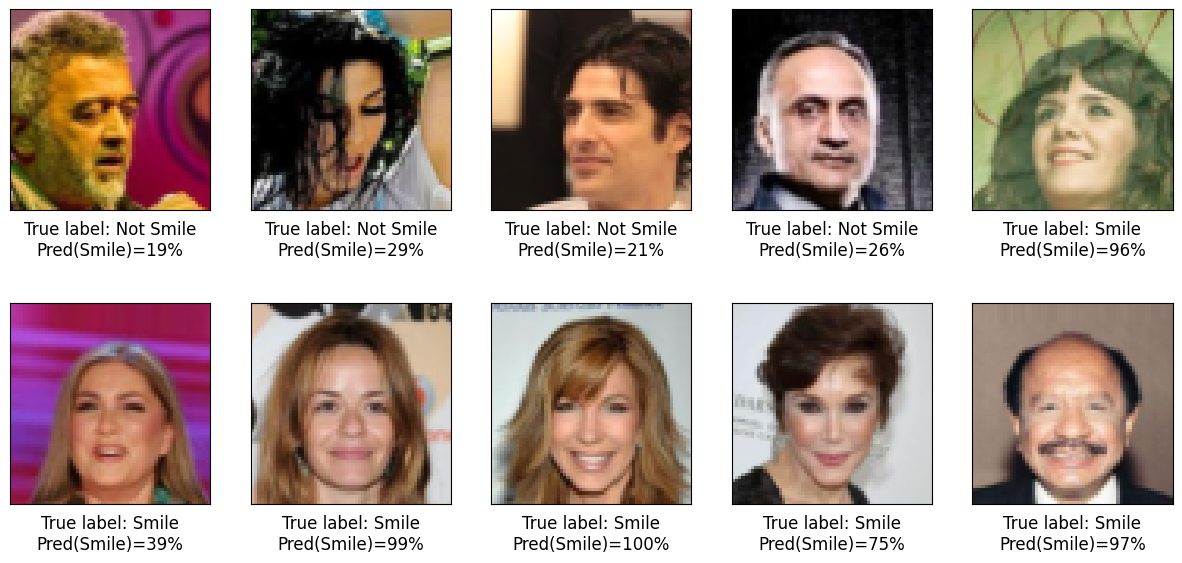

In [255]:
x_batch = x_batch.to(device)
pred = model(x_batch)[:, 0] * 100


fig = plt.figure(figsize=(15, 7))
num_images = min(len(x_batch), 20)

for j in range(10, num_images):
    ax = fig.add_subplot(2, 5, j - 10 + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    img = x_batch[j].cpu().permute(1, 2, 0).numpy()
    ax.imshow(img)

    # determine the ground truth label
    label = 'Smile' if y_batch[j].cpu().item() == 1 else 'Not Smile'
    ax.text(
        0.5, -0.15, 
        f'True label: {label:s}\nPred(Smile)={pred[j].cpu().item():.0f}%', 
        size=12, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes
    )

plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()